In [ ]:
!kaggle competitions download -c ai-talent-hub-ml-2-v2


 98% 1.05G/1.07G [00:17<00:00, 90.8MB/s]
100% 1.07G/1.07G [00:17<00:00, 64.6MB/s]


In [ ]:
!pip install kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!unzip ai-talent-hub-ml-2-v2.zip

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
df = pd.DataFrame(pd.read_csv('train_dataset.csv'))
test_df = pd.DataFrame(pd.read_csv('test_dataset.csv'))

In [ ]:

class TriangleCounter(nn.Module):
    def __init__(self, num_classes):
        super(TriangleCounter, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.resnet(x)


class TriangleDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [ ]:
image_paths = ['/content/train_images' + df.iloc[i,1] for i in range(len(df))]
labels = [df.iloc[i,2] for i in range(len(df))]

In [ ]:

dataset = TriangleDataset(image_paths, labels, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
len(dataloader)

94

In [ ]:

num_classes = max(labels) + 1
model = TriangleCounter(num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


num_epochs = 40
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [ ]:
def rmse(predictions, targets):
    return torch.sqrt(torch.mean((predictions - targets) ** 2))

In [ ]:
metric = nn.MSELoss()

In [ ]:

for epoch in range(num_epochs):
    model.train()
    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        #rmse_torch = torch.sqrt(metric(outputs, labels))
        #, RMSE: {rmse_torch.item():.4f}


    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

def predict(image_path):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image)
        predicted = torch.argmax(output, 1)

    return predicted.item()


print(predict('/content/test_images/test_images/test_1.png'))

KeyboardInterrupt: 

In [ ]:
predicted_path = ['/content/test_images' + test_df.iloc[i,1] for i in range(len(test_df))]

In [ ]:
predicted_counts = [predict(i) for i in predicted_path]

In [ ]:
predicted_counts[3]

12

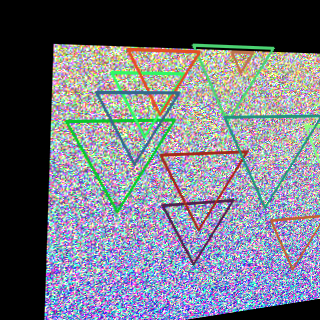

In [ ]:
from PIL import Image
im = Image.open('/content/test_images/test_images/test_4.png')
im

In [ ]:
result = pd.DataFrame()

result['target'] = predicted_counts

In [ ]:
result['ID'] = test_df['ID']

In [ ]:
result

In [ ]:
result.to_csv('/content/cv_pred4.csv', index = False)